<a href="https://colab.research.google.com/github/tzjZhengJie/DataAnalyst_Project/blob/Python/fyp_news_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
class Params:
    def __init__(self):
        self.years_ago = 5
        self.start_date = self.get_start_date(self.years_ago)
        self.end_date = datetime.today()
        self.risk_free_rate = .045

    def get_start_date(self, years_ago):
        return datetime.today() - timedelta(days=years_ago * 365)

class Stock_Data:
    def __init__(self, tickers):
      self.tickers = tickers

    def fetch_stock_data(self, params):
        dfs = [yf.download(ticker, start=params.start_date, end=params.end_date)[['Adj Close']].rename(columns={'Adj Close': ticker}) for ticker in self.tickers]
        adj_close_df = pd.concat(dfs, axis=1)
        adj_close_df = adj_close_df.dropna()#cleaning
        print(f"\nFetched data for {', '.join(self.tickers)} from {params.start_date} to {params.end_date}")
        return adj_close_df

class Calculation:
    def __init__(self):
       pass

    def log_returns_cal(self, adj_close_df):
        log_returns = np.log(adj_close_df/ adj_close_df.shift(1))
        return log_returns

    def cov_matrix_cal(self,log_returns):
        cov_matrix = log_returns.cov()*252 #annualized
        return cov_matrix

    def standard_deviation(self, weights, cov_matrix):
        variance = weights.T @ cov_matrix @ weights
        return np.sqrt(variance)

    def expected_return(self, weights, log_returns):
        return np.sum(log_returns.mean()*weights)*252

    def sharpe_ratio(self, weights, log_returns, cov_matrix, risk_free_rate): # sharpe ratio = (portfolio returns - risk free rate) / st.dev
        return (self.expected_return(weights, log_returns) - risk_free_rate) / self.standard_deviation(weights, cov_matrix)

    def neg_sharpe_ratio(self, weights, log_returns, cov_matrix, risk_free_rate):
        return -self.sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) #minimize function as scipy can't detect max value, thus sharpe_ratio becomes negative

    # SLSQP Optimization
    # scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

    def SLSQP(self, constraints, bounds, initial_weights, log_returns, cov_matrix, risk_free_rate):
        optimized_results = minimize(self.neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds) #scipy.optimize.minimize() function
        return optimized_results

In [ ]:
    #Specify Tickers
    tickers = ['JYEU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI', 'N2IU.SI']

    #Instances
    params = Params()
    stock_data = Stock_Data(tickers)
    calculation = Calculation()

In [ ]:
# Fetch stock data
result_df = stock_data.fetch_stock_data(params)
result_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetched data for JYEU.SI, J69U.SI, BUOU.SI, SK6U.SI, N2IU.SI from 2019-02-06 07:35:13.032625 to 2024-02-05 07:35:13.032640


,JYEU.SI,J69U.SI,BUOU.SI,SK6U.SI,N2IU.SI
Date,,,,,
2019-10-02,0.737227,2.157398,0.974529,0.888776,1.851411
2019-10-03,0.733221,2.173320,0.966732,0.896930,1.851411
2019-10-04,0.749247,2.181281,0.966732,0.905084,1.867371
2019-10-07,0.765274,2.205163,0.974529,0.896930,1.875352
2019-10-08,0.765274,2.205163,0.982325,0.905084,1.883332
...,...,...,...,...,...
2024-01-29,0.610000,2.208424,1.070000,0.855000,1.369055
2024-01-30,0.625000,2.237870,1.080000,0.855000,1.418301
2024-01-31,0.630000,2.257500,1.120000,0.875000,1.438000


In [ ]:
#Mean Calculation
meanReturns = result_df.mean()
meanReturns

JYEU.SI    0.663012
J69U.SI    2.045219
BUOU.SI    1.146839
SK6U.SI    0.829127
N2IU.SI    1.665635
dtype: float64

In [ ]:
#Log returns
#Stabalise the variance data for optimisation
log_returns = calculation.log_returns_cal(result_df)
log_returns

,JYEU.SI,J69U.SI,BUOU.SI,SK6U.SI,N2IU.SI
Date,,,,,
2019-10-02,NaN,NaN,NaN,NaN,NaN
2019-10-03,-0.005450,0.007353,-0.008032,0.009133,0.000000
2019-10-04,0.021622,0.003656,0.000000,0.009050,0.008583
2019-10-07,0.021165,0.010889,0.008032,-0.009050,0.004265
2019-10-08,0.000000,0.000000,0.007968,0.009050,0.004246
...,...,...,...,...,...
2024-01-29,-0.008163,0.013423,-0.009302,-0.017392,-0.014286
2024-01-30,0.024293,0.013245,0.009302,0.000000,0.035339
2024-01-31,0.007968,0.008734,0.036368,0.023122,0.013793


**Calculate Covariance Matrix**





In [ ]:
#Covariance matrix
cov_matrix = calculation.cov_matrix_cal(log_returns)
cov_matrix

,JYEU.SI,J69U.SI,BUOU.SI,SK6U.SI,N2IU.SI
JYEU.SI,0.083128,0.036966,0.032605,0.023776,0.036637
J69U.SI,0.036966,0.067838,0.042486,0.028841,0.041581
BUOU.SI,0.032605,0.042486,0.084702,0.031005,0.039303
SK6U.SI,0.023776,0.028841,0.031005,0.047028,0.025802
N2IU.SI,0.036637,0.041581,0.039303,0.025802,0.063991


SLSQP Optimisation

In [ ]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} #weights = 1
bounds = [(0.1, 0.4) for _ in range(len(stock_data.tickers))] #lower bound and upper bound for weightage of securities
initial_weights = np.array([1/len(stock_data.tickers)]*len(stock_data.tickers)) #equal weights

#constraints, bounds, initial_weights, log_returns, cov_matrix, risk_free_rate
optimized_results = calculation.SLSQP(constraints, bounds, initial_weights, log_returns, cov_matrix, params.risk_free_rate)

In [ ]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(stock_data.tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = calculation.expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = calculation.standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = calculation.sharpe_ratio(optimal_weights, log_returns, cov_matrix, params.risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
JYEU.SI: 0.1000
J69U.SI: 0.3000
BUOU.SI: 0.4000
SK6U.SI: 0.1000
N2IU.SI: 0.1000
Expected Annual Return: 0.0072
Expected Volatility: 0.2195
Sharpe Ratio: -0.1721


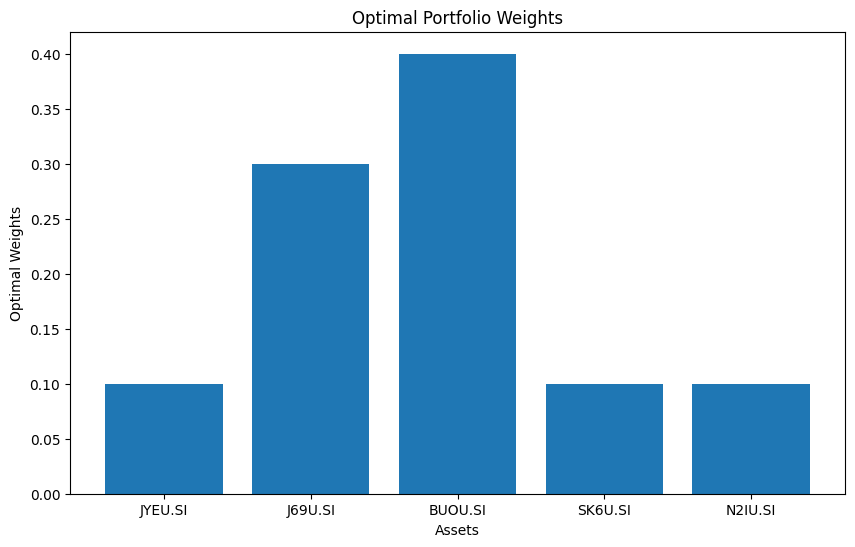

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(stock_data.tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

##Dividends and price action
#Compile the every recorded dividends timeframe and find the average 14 days return after the recorded date

In [ ]:
import yfinance as yf
import pandas as pd

# List of stock ticker symbols
tickers = ['JYEU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI', 'N2IU.SI']
days_after_ex_date_start = 2  # Start of the range of days after ex-date
days_after_ex_date_end = 2  # End of the range of days after ex-date

# Create an empty list to store price movements
price_movements = []

for ticker in tickers:
    # Get the stock data
    stock = yf.Ticker(ticker)

    # Download historical data
    data = stock.history(period='max')  # Adjust the period as needed

    # Find all dividend ex-dates
    dividends = stock.dividends
    if not dividends.empty:
        ex_dates = dividends.index

        for ex_date in ex_dates:
            print(f"Dividend ex-date for {ticker}: {ex_date.date()}")

            # Calculate the price movement after the dividend ex-date for a range of days
            for days_after in range(days_after_ex_date_start, days_after_ex_date_end + 1):
                start_date = ex_date + pd.Timedelta(days=days_after)
                if start_date in data.index:
                    start_price = data.loc[start_date, 'Open']
                    end_date = ex_date + pd.Timedelta(days=days_after)
                    end_price = data.loc[end_date, 'Close']
                    price_change = (end_price - start_price) / start_price * 100

                    # Append the data to the price_movements list
                    price_movements.append({'Ex_Date': ex_date, 'Ticker': ticker, f'Price_change_{days_after}_days_after %': price_change})
                else:
                    print(f"Insufficient data for {ticker} to calculate the price change {days_after} days after the dividend ex-date.")
    else:
        print(f"No dividend ex-date found for {ticker}.")

    print("-" * 30)

# Convert the list of dictionaries to a DataFrame using pd.concat
price_movement_df = pd.concat([pd.DataFrame([movement]) for movement in price_movements], ignore_index=True)

# Print the final price_movement_df DataFrame
print(price_movement_df)


Dividend ex-date for JYEU.SI: 2020-02-17
Dividend ex-date for JYEU.SI: 2020-08-18
Dividend ex-date for JYEU.SI: 2021-02-18
Insufficient data for JYEU.SI to calculate the price change 2 days after the dividend ex-date.
Dividend ex-date for JYEU.SI: 2021-08-17
Dividend ex-date for JYEU.SI: 2022-02-14
Dividend ex-date for JYEU.SI: 2022-03-29
Dividend ex-date for JYEU.SI: 2022-08-17
Dividend ex-date for JYEU.SI: 2023-02-14
Dividend ex-date for JYEU.SI: 2023-08-15
Dividend ex-date for JYEU.SI: 2024-02-08
Insufficient data for JYEU.SI to calculate the price change 2 days after the dividend ex-date.
------------------------------
Dividend ex-date for J69U.SI: 2008-01-30
Dividend ex-date for J69U.SI: 2008-04-30
Dividend ex-date for J69U.SI: 2008-08-01
Insufficient data for J69U.SI to calculate the price change 2 days after the dividend ex-date.
Dividend ex-date for J69U.SI: 2008-10-31
Insufficient data for J69U.SI to calculate the price change 2 days after the dividend ex-date.
Dividend ex-dat

In [ ]:
# Filter the DataFrame for the ticker 'BUOU.SI'
buou_result_df = price_movement_df[price_movement_df['Ticker'] == 'JYEU.SI']

# Print the result DataFrame for the ticker 'BUOU.SI'
print(buou_result_df)


                    Ex_Date   Ticker  Price_change_1_days_after %
0 2020-02-17 00:00:00+08:00  JYEU.SI                 5.555573e-01
1 2020-08-18 00:00:00+08:00  JYEU.SI                 1.156756e-14
2 2021-02-18 00:00:00+08:00  JYEU.SI                -6.289323e-01
3 2021-08-17 00:00:00+08:00  JYEU.SI                 4.705852e+00
4 2022-02-14 00:00:00+08:00  JYEU.SI                 1.818172e+00
5 2022-03-29 00:00:00+08:00  JYEU.SI                -1.910834e+00
6 2022-08-17 00:00:00+08:00  JYEU.SI                 2.439022e+00
7 2023-02-14 00:00:00+08:00  JYEU.SI                -2.836877e+00
8 2023-08-15 00:00:00+08:00  JYEU.SI                -1.626015e+00
9 2024-02-08 00:00:00+08:00  JYEU.SI                 8.547001e-01


In [ ]:
# Calculate the standard deviation of price changes for each ticker
# Calculate the average price change
average_price_changes = price_movement_df.groupby(['Ticker']).mean(numeric_only=True)
print(f"Price action after {days_after_ex_date_end} days of dividends recording")
print("---------------------------------------")
print("avg:", average_price_changes)
volatility = price_movement_df.groupby(['Ticker']).std(numeric_only=True)
print("sd:", volatility)


Price action after 2 days of dividends recording
---------------------------------------
avg:          Price_change_2_days_after %
Ticker                              
BUOU.SI                     0.073217
J69U.SI                    -0.186594
JYEU.SI                    -0.007288
N2IU.SI                    -0.057259
SK6U.SI                     0.017000
sd:          Price_change_2_days_after %
Ticker                              
BUOU.SI                     0.690439
J69U.SI                     0.954004
JYEU.SI                     0.618123
N2IU.SI                     0.954959
SK6U.SI                     0.955900


In [ ]:
# Filter the DataFrame for negative and positive returns for each ticker
negative_returns = price_movement_df[price_movement_df[f'Price_change_{days_after_ex_date_end}_days_after %'] < 0]
positive_returns = price_movement_df[price_movement_df[f'Price_change_{days_after_ex_date_end}_days_after %'] > 0]

# Count the occurrences of negative and positive returns for each ticker
negative_returns_count = negative_returns.groupby('Ticker').size()
positive_returns_count = positive_returns.groupby('Ticker').size()

# Display the results
print("Negative Returns:")
print(negative_returns_count)
print("\nPositive Returns:")
print(positive_returns_count)


Negative Returns:
Ticker
BUOU.SI     8
J69U.SI    28
JYEU.SI     6
N2IU.SI    24
SK6U.SI    12
dtype: int64

Positive Returns:
Ticker
BUOU.SI     9
J69U.SI    32
JYEU.SI     4
N2IU.SI    23
SK6U.SI    27
dtype: int64


In [ ]:
import yfinance as yf
import pandas as pd

# List of stock ticker symbols
tickers = ['JYEU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI', 'N2IU.SI']
days_before_ex_date_start = 2  # Start of the range of days before ex-date
days_before_ex_date_end = 2  # End of the range of days before ex-date

# Create an empty list to store price movements
price_movements = []

for ticker in tickers:
    # Get the stock data
    stock = yf.Ticker(ticker)

    # Download historical data
    data = stock.history(period='max')  # Adjust the period as needed

    # Find all dividend ex-dates
    dividends = stock.dividends
    if not dividends.empty:
        ex_dates = dividends.index

        for ex_date in ex_dates:
            print(f"Dividend ex-date for {ticker}: {ex_date.date()}")

            # Calculate the price movement before the dividend ex-date for a range of days
            for days_before in range(days_before_ex_date_start, days_before_ex_date_end + 1):
                start_date = ex_date - pd.Timedelta(days=days_before)
                if start_date in data.index:
                    start_price = data.loc[start_date, 'Open']
                    end_date = ex_date
                    end_price = data.loc[end_date, 'Close']
                    price_change = (end_price - start_price) / start_price * 100

                    # Append the data to the price_movements list
                    price_movements.append({'Ex_Date': ex_date, 'Ticker': ticker, f'Price_change_{days_before}_days_before %': price_change})
                else:
                    print(f"Insufficient data for {ticker} to calculate the price change {days_before} days before the dividend ex-date.")
    else:
        print(f"No dividend ex-date found for {ticker}.")

    print("-" * 30)

# Convert the list of dictionaries to a DataFrame using pd.concat
price_movement_df = pd.concat([pd.DataFrame([movement]) for movement in price_movements], ignore_index=True)

# Print the final price_movement_df DataFrame
print(price_movement_df)


Dividend ex-date for JYEU.SI: 2020-02-17
Insufficient data for JYEU.SI to calculate the price change 2 days before the dividend ex-date.
Dividend ex-date for JYEU.SI: 2020-08-18
Insufficient data for JYEU.SI to calculate the price change 2 days before the dividend ex-date.
Dividend ex-date for JYEU.SI: 2021-02-18
Dividend ex-date for JYEU.SI: 2021-08-17
Insufficient data for JYEU.SI to calculate the price change 2 days before the dividend ex-date.
Dividend ex-date for JYEU.SI: 2022-02-14
Insufficient data for JYEU.SI to calculate the price change 2 days before the dividend ex-date.
Dividend ex-date for JYEU.SI: 2022-03-29
Insufficient data for JYEU.SI to calculate the price change 2 days before the dividend ex-date.
Dividend ex-date for JYEU.SI: 2022-08-17
Dividend ex-date for JYEU.SI: 2023-02-14
Insufficient data for JYEU.SI to calculate the price change 2 days before the dividend ex-date.
Dividend ex-date for JYEU.SI: 2023-08-15
Insufficient data for JYEU.SI to calculate the price ch

In [ ]:
# Filter the DataFrame for negative and positive returns for each ticker
negative_returns = price_movement_df[price_movement_df[f'Price_change_{days_before_ex_date_start}_days_before %'] < 0]
positive_returns = price_movement_df[price_movement_df[f'Price_change_{days_before_ex_date_start}_days_before %'] >= 0]

# Count the occurrences of negative and positive returns for each ticker
negative_returns_count = negative_returns.groupby('Ticker').size()
positive_returns_count = positive_returns.groupby('Ticker').size()

# Display the results
print("Negative Returns:")
print(negative_returns_count)
print("\nPositive Returns:")
print(positive_returns_count)


Negative Returns:
Ticker
BUOU.SI     6
J69U.SI    20
JYEU.SI     5
N2IU.SI    20
SK6U.SI     9
dtype: int64

Positive Returns:
Ticker
BUOU.SI     6
J69U.SI    24
JYEU.SI     3
N2IU.SI    20
SK6U.SI    22
dtype: int64


In [ ]:
# Calculate the standard deviation of price changes for each ticker
# Calculate the average price change
average_price_changes = price_movement_df.groupby(['Ticker']).mean(numeric_only=True)
print(f"Price action before {days_before_ex_date_end} days of dividends recording")
print("---------------------------------------")
print("avg:", average_price_changes)
volatility = price_movement_df.groupby(['Ticker']).std(numeric_only=True)
print("sd:", volatility)


Price action before 2 days of dividends recording
---------------------------------------
avg:          Price_change_2_days_before %
Ticker                               
BUOU.SI                     -0.950851
J69U.SI                      0.932117
JYEU.SI                     -0.295322
N2IU.SI                      0.363271
SK6U.SI                      0.563824
sd:          Price_change_2_days_before %
Ticker                               
BUOU.SI                      1.424053
J69U.SI                      3.097701
JYEU.SI                      1.786397
N2IU.SI                      3.000190
SK6U.SI                      1.929026


##Earnings vs price action
#March 17 2022 is where the first rate hike started
#Let us see what is the effect on S-REITs for 4 earning reports from a timeframe of 2022-2024


Let us visualise and have insights from the returns of the stocks ever since 17 march 2022, which most likely is a bear market


[*********************100%%**********************]  5 of 5 completed


Cumulative Returns Since March 17, 2022:
Ticker        BUOU.SI   J69U.SI    JYEU.SI    N2IU.SI    SK6U.SI
Date                                                            
2024-03-12 -28.275867 -4.782604 -25.273624 -29.787231 -13.157895


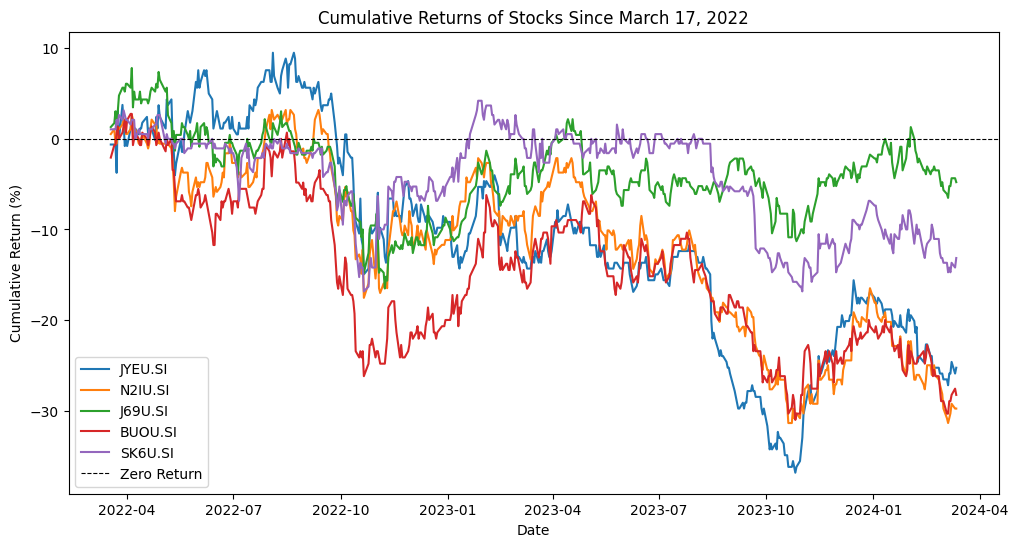

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of stock ticker symbols
tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']

# Download historical data
data = yf.download(tickers, start='2022-03-17', end=pd.to_datetime('today').strftime('%Y-%m-%d'))

# Calculate cumulative returns since March 17, 2022
cumulative_returns = (1 + data['Close'].pct_change()).cumprod() - 1
# Print the cumulative returns for each ticker
print("Cumulative Returns Since March 17, 2022:")
print(cumulative_returns.tail(1)*100)


# Plot the cumulative returns
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker] * 100, label=ticker)

plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Return')
plt.title('Cumulative Returns of Stocks Since March 17, 2022')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.show()


Now let us see the some of earnings vs price action ever since 17 march 2022

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone

# List of stock ticker symbols
tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']

earning_record_dates = {
    'JYEU.SI': ['2024-02-01', '2023-08-07', '2023-02-07', '2022-08-08'],
    'N2IU.SI': ['2024-01-29', '2023-10-26', '2023-07-31', '2023-04-27'],
    'J69U.SI': ['2023-10-25', '2023-04-25', '2022-10-26', '2022-04-27'],
    'BUOU.SI': ['2024-01-30', '2023-11-02', '2023-08-01', '2023-05-04'],
    'SK6U.SI': ['2024-02-06', '2023-08-07', '2023-02-13', '2022-10-10']
}
days = 3  # Modify this value to change the number of days

# Create an empty list to store price movements
price_movements = []

for ticker in tickers:
    # Get the stock data
    stock = yf.Ticker(ticker)

    # Download historical data
    data = stock.history(period='max')  # Adjust the period as needed

    # Iterate through each earning record date for the current ticker
    for record_date in earning_record_dates[ticker]:
        record_date = pd.to_datetime(record_date)

        end_date = record_date
        end_date += pd.Timedelta(days=days)

        if end_date in data.index:
            start_price = data.loc[record_date, 'Open']
            end_price = data.loc[end_date, 'Close']
            price_change = (end_price - start_price) / start_price * 100
            print(f"Price change for {ticker} from {record_date.date()} to {end_date.date()} ({days} days): {price_change:.2f}%")

            # Append the data to the price_movements list
            price_movements.append({
                'Ticker': ticker,
                'Start_Date': record_date,
                'End_Date': end_date,
                'Price_change %': price_change
            })
        else:
            print(f"Insufficient data for {ticker} to calculate the price change within {days} days after {record_date.date()}.")

    print("-" * 30)

# Convert the list of dictionaries to a DataFrame using pd.concat
price_movement_df = pd.concat([pd.DataFrame([movement]) for movement in price_movements], ignore_index=True)

# Print the final price_movement_df DataFrame
print(price_movement_df)


<ipython-input-64-a7db614b20a4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-64-a7db614b20a4>:36: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[record_date, 'Open']
<ipython-input-64-a7db614b20a4>:37: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']
<ipython-input-64-a7db614b20a4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_da

Insufficient data for JYEU.SI to calculate the price change within 3 days after 2024-02-01.
Price change for JYEU.SI from 2023-08-07 to 2023-08-10 (3 days): -1.48%
Price change for JYEU.SI from 2023-02-07 to 2023-02-10 (3 days): 0.68%
Price change for JYEU.SI from 2022-08-08 to 2022-08-11 (3 days): 0.00%
------------------------------
Price change for N2IU.SI from 2024-01-29 to 2024-02-01 (3 days): 1.42%
Insufficient data for N2IU.SI to calculate the price change within 3 days after 2023-10-26.
Price change for N2IU.SI from 2023-07-31 to 2023-08-03 (3 days): -4.17%
Insufficient data for N2IU.SI to calculate the price change within 3 days after 2023-04-27.
------------------------------


<ipython-input-64-a7db614b20a4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-64-a7db614b20a4>:36: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[record_date, 'Open']
<ipython-input-64-a7db614b20a4>:37: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']
<ipython-input-64-a7db614b20a4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_da

Insufficient data for J69U.SI to calculate the price change within 3 days after 2023-10-25.
Price change for J69U.SI from 2023-04-25 to 2023-04-28 (3 days): -4.74%
Insufficient data for J69U.SI to calculate the price change within 3 days after 2022-10-26.
Insufficient data for J69U.SI to calculate the price change within 3 days after 2022-04-27.
------------------------------
Price change for BUOU.SI from 2024-01-30 to 2024-02-02 (3 days): 3.74%
Insufficient data for BUOU.SI to calculate the price change within 3 days after 2023-11-02.
Price change for BUOU.SI from 2023-08-01 to 2023-08-04 (3 days): 0.81%
Insufficient data for BUOU.SI to calculate the price change within 3 days after 2023-05-04.
------------------------------
Price change for SK6U.SI from 2024-02-06 to 2024-02-09 (3 days): 1.79%
Price change for SK6U.SI from 2023-08-07 to 2023-08-10 (3 days): 0.00%
Price change for SK6U.SI from 2023-02-13 to 2023-02-16 (3 days): -0.52%
Price change for SK6U.SI from 2022-10-10 to 2022-1

<ipython-input-64-a7db614b20a4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-64-a7db614b20a4>:36: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[record_date, 'Open']
<ipython-input-64-a7db614b20a4>:37: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']


In [ ]:
print(price_movement_df)

     Ticker Start_Date   End_Date  Price_change %
0   JYEU.SI 2024-02-01 2024-02-08       -3.099062
1   JYEU.SI 2023-08-07 2023-08-14       -2.222213
2   JYEU.SI 2023-02-07 2023-02-14       -0.745722
3   JYEU.SI 2022-08-08 2022-08-15        1.807235
4   N2IU.SI 2024-01-29 2024-02-05       -0.630307
5   N2IU.SI 2023-10-26 2023-11-02        3.303412
6   N2IU.SI 2023-07-31 2023-08-07       -4.653272
7   N2IU.SI 2023-04-27 2023-05-04       -3.888883
8   J69U.SI 2023-10-25 2023-11-01       -1.428566
9   J69U.SI 2023-04-25 2023-05-02       -4.310344
10  J69U.SI 2022-10-26 2022-11-02        5.021743
11  J69U.SI 2022-04-27 2022-05-04       -1.224486
12  BUOU.SI 2024-01-30 2024-02-06        1.869157
13  BUOU.SI 2023-11-02 2023-11-09        3.337125
14  BUOU.SI 2023-08-01 2023-08-08        0.813007
15  BUOU.SI 2023-05-04 2023-05-11       -0.373606
16  SK6U.SI 2024-02-06 2024-02-13        1.908492
17  SK6U.SI 2023-08-07 2023-08-14        0.000001
18  SK6U.SI 2023-02-13 2023-02-20        1.277721


In [ ]:
# Calculate the standard deviation of price changes for each ticker
# Calculate the average price change
average_price_changes = price_movement_df.groupby(['Ticker']).mean(numeric_only=True)
print("Price action earnings release 3 days after (bear market)")
print("---------------------------------------")
print("avg:", average_price_changes)
volatility = price_movement_df.groupby(['Ticker']).std(numeric_only=True)
print("sd:", volatility)


Price action earnings release 3 days after (bear market)
---------------------------------------
avg:          Price_change %
Ticker                 
BUOU.SI        2.275661
J69U.SI       -4.741379
JYEU.SI       -0.268601
N2IU.SI       -1.374115
SK6U.SI       -0.248074
sd:          Price_change %
Ticker                 
BUOU.SI        2.068504
J69U.SI             NaN
JYEU.SI        1.103378
N2IU.SI        3.949268
SK6U.SI        1.665147


##What about price action on earnings before the rate hike started?
#Test on a bull market year
#Let us plot out the returns of 1 of a bull market

[*********************100%%**********************]  5 of 5 completed


Cumulative Returns of the bull market:
Ticker        BUOU.SI    J69U.SI   JYEU.SI    N2IU.SI    SK6U.SI
Date                                                            
2021-12-30  77.777772  10.723068  71.15382  14.285714  34.666665


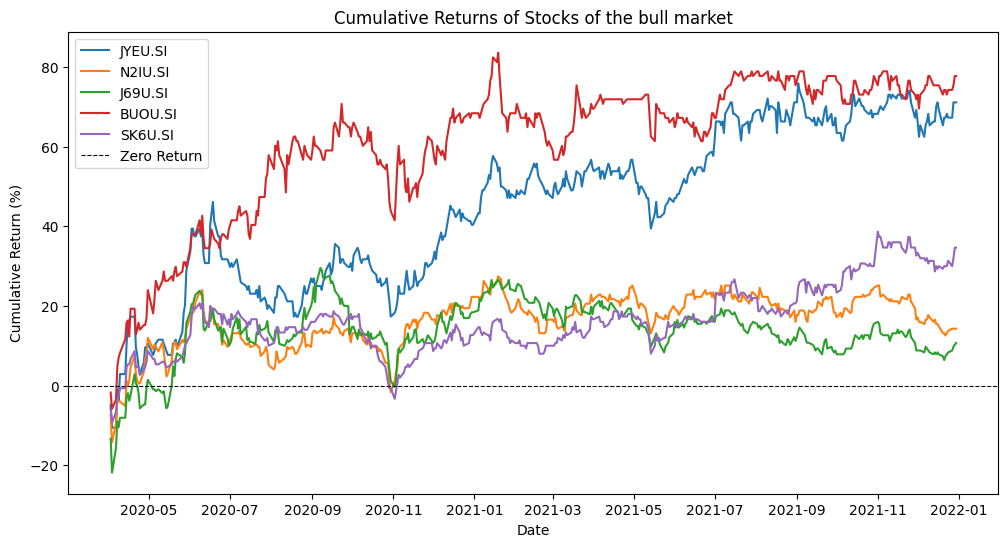

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of stock ticker symbols
tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']

# Download historical data
data = yf.download(tickers, start='2020-04-01', end='2021-12-31')

# Calculate cumulative returns since March 17, 2022
cumulative_returns = (1 + data['Close'].pct_change()).cumprod() - 1
# Print the cumulative returns for each ticker
print("Cumulative Returns of the bull market:")
print(cumulative_returns.tail(1)*100)


# Plot the cumulative returns
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker] * 100, label=ticker)

plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Return')
plt.title('Cumulative Returns of Stocks of the bull market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.show()


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone

# List of stock ticker symbols
tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']

earning_record_dates = {
    'JYEU.SI': ['2020-05-05', '2020-08-11', '2021-02-10', '2021-08-10'],
    'N2IU.SI': ['2020-04-22', '2020-10-22', '2021-04-27', '2021-10-27'],
    'J69U.SI': ['2020-04-23', '2020-11-03', '2021-08-26', '2021-10-27'],
    'BUOU.SI': ['2020-05-04', '2020-11-06', '2021-05-10', '2021-11-11'],
    'SK6U.SI': ['2020-04-01', '2020-10-06', '2021-03-29', '2021-10-04']
}
days = 30  # Modify this value to change the number of days

# Create an empty list to store price movements
price_movements = []

for ticker in tickers:
    # Get the stock data
    stock = yf.Ticker(ticker)

    # Download historical data
    data = stock.history(period='max')  # Adjust the period as needed

    # Iterate through each earning record date for the current ticker
    for record_date in earning_record_dates[ticker]:
        record_date = pd.to_datetime(record_date)

        end_date = record_date
        end_date += pd.Timedelta(days=days)

        if end_date in data.index:
            start_price = data.loc[record_date, 'Open']
            end_price = data.loc[end_date, 'Close']
            price_change = (end_price - start_price) / start_price * 100
            print(f"Price change for {ticker} from {record_date.date()} to {end_date.date()} ({days} days): {price_change:.2f}%")

            # Append the data to the price_movements list
            price_movements.append({
                'Ticker': ticker,
                'Start_Date': record_date,
                'End_Date': end_date,
                'Price_change %': price_change
            })
        else:
            print(f"Insufficient data for {ticker} to calculate the price change within {days} days after {record_date.date()}.")

    print("-" * 30)

# Convert the list of dictionaries to a DataFrame using pd.concat
price_movement_df = pd.concat([pd.DataFrame([movement]) for movement in price_movements], ignore_index=True)

# Print the final price_movement_df DataFrame
print(price_movement_df)


<ipython-input-75-6a53eca61db4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-75-6a53eca61db4>:36: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[record_date, 'Open']
<ipython-input-75-6a53eca61db4>:37: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']
<ipython-input-75-6a53eca61db4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_da

Price change for JYEU.SI from 2020-05-05 to 2020-06-04 (30 days): 24.35%
Price change for JYEU.SI from 2020-08-11 to 2020-09-10 (30 days): 6.09%
Price change for JYEU.SI from 2021-02-10 to 2021-03-12 (30 days): 4.30%
Price change for JYEU.SI from 2021-08-10 to 2021-09-09 (30 days): 2.73%
------------------------------
Price change for N2IU.SI from 2020-04-22 to 2020-05-22 (30 days): 9.05%
Insufficient data for N2IU.SI to calculate the price change within 30 days after 2020-10-22.
Price change for N2IU.SI from 2021-04-27 to 2021-05-27 (30 days): -2.24%
Price change for N2IU.SI from 2021-10-27 to 2021-11-26 (30 days): 0.62%
------------------------------


<ipython-input-75-6a53eca61db4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-75-6a53eca61db4>:36: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[record_date, 'Open']
<ipython-input-75-6a53eca61db4>:37: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']
<ipython-input-75-6a53eca61db4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_da

Insufficient data for J69U.SI to calculate the price change within 30 days after 2020-04-23.
Price change for J69U.SI from 2020-11-03 to 2020-12-03 (30 days): 12.44%
Insufficient data for J69U.SI to calculate the price change within 30 days after 2021-08-26.
Price change for J69U.SI from 2021-10-27 to 2021-11-26 (30 days): 2.16%
------------------------------
Price change for BUOU.SI from 2020-05-04 to 2020-06-03 (30 days): 14.56%
Insufficient data for BUOU.SI to calculate the price change within 30 days after 2020-11-06.
Price change for BUOU.SI from 2021-05-10 to 2021-06-09 (30 days): 0.06%
Insufficient data for BUOU.SI to calculate the price change within 30 days after 2021-11-11.
------------------------------
Insufficient data for SK6U.SI to calculate the price change within 30 days after 2020-04-01.
Price change for SK6U.SI from 2020-10-06 to 2020-11-05 (30 days): -12.42%
Price change for SK6U.SI from 2021-03-29 to 2021-04-28 (30 days): 5.61%
Price change for SK6U.SI from 2021-10

<ipython-input-75-6a53eca61db4>:35: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-75-6a53eca61db4>:36: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[record_date, 'Open']
<ipython-input-75-6a53eca61db4>:37: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']


In [ ]:
# Calculate the standard deviation of price changes for each ticker
# Calculate the average price change
average_price_changes = price_movement_df.groupby(['Ticker']).mean(numeric_only=True)
print("Price action after earnings 3 days later (bull market)")
print("---------------------------------------")
print("avg:", average_price_changes)
volatility = price_movement_df.groupby(['Ticker']).std(numeric_only=True)
print("sd:", volatility)


Price action after earnings 3 days later (bull market)
---------------------------------------
avg:          Price_change %
Ticker                 
BUOU.SI        7.311993
J69U.SI        7.297844
JYEU.SI        9.363482
N2IU.SI        2.477477
SK6U.SI        1.919380
sd:          Price_change %
Ticker                 
BUOU.SI       10.254624
J69U.SI        7.272387
JYEU.SI       10.083426
N2IU.SI        5.872248
SK6U.SI       12.902006


#Now let us test the price action for every 2022 fed meetings
##Get insight of the price action of the next day after fed meeting


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timezone

# List of stock ticker symbols
tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']

fed_meeting_dates = [
    '2022-03-17', '2022-06-17', '2022-09-22', '2022-12-15'
]

days = 0  # We ar i ce looking for the price action after fed's meeting

# Create an empty list to store price movements
price_movements = []

for ticker in tickers:
    # Get the stock data
    stock = yf.Ticker(ticker)

    # Download historical data
    data = stock.history(period='max')  # Adjust the period as needed

    # Iterate through each Fed meeting date for the current ticker
    for meeting_date in fed_meeting_dates:
        meeting_date = pd.to_datetime(meeting_date)

        end_date = meeting_date
        end_date += pd.Timedelta(days=days)

        if end_date in data.index:
            start_price = data.loc[meeting_date, 'Open']
            end_price = data.loc[end_date, 'Close']
            price_change = (end_price - start_price) / start_price * 100
            print(f"Price change for {ticker} from {meeting_date.date()} to {end_date.date()} ({days} day): {price_change:.2f}%")

            # Append the data to the price_movements list
            price_movements.append({
                'Ticker': ticker,
                'Fed_Meeting_Date': meeting_date,
                'Next_Day_Date': end_date,
                'Price_change %': price_change
            })
        else:
            print(f"Insufficient data for {ticker} to calculate the price change within {days} day after {meeting_date.date()}.")

    print("-" * 30)

# Convert the list of dictionaries to a DataFrame using pd.concat
price_movement_df = pd.concat([pd.DataFrame([movement]) for movement in price_movements], ignore_index=True)

# Print the final price_movement_df DataFrame
print(price_movement_df)


<ipython-input-77-0e6329e866c8>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-77-0e6329e866c8>:32: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-77-0e6329e866c8>:33: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']
<ipython-input-77-0e6329e866c8>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_d

Price change for JYEU.SI from 2022-03-17 to 2022-03-17 (0 day): 0.63%
Price change for JYEU.SI from 2022-06-17 to 2022-06-17 (0 day): 1.27%
Price change for JYEU.SI from 2022-09-22 to 2022-09-22 (0 day): 0.62%
Price change for JYEU.SI from 2022-12-15 to 2022-12-15 (0 day): -0.70%
------------------------------
Price change for N2IU.SI from 2022-03-17 to 2022-03-17 (0 day): 1.62%
Price change for N2IU.SI from 2022-06-17 to 2022-06-17 (0 day): -0.56%
Price change for N2IU.SI from 2022-09-22 to 2022-09-22 (0 day): -0.54%
Price change for N2IU.SI from 2022-12-15 to 2022-12-15 (0 day): 0.00%
------------------------------
Price change for J69U.SI from 2022-03-17 to 2022-03-17 (0 day): 0.44%
Price change for J69U.SI from 2022-06-17 to 2022-06-17 (0 day): 0.90%
Price change for J69U.SI from 2022-09-22 to 2022-09-22 (0 day): 0.44%
Price change for J69U.SI from 2022-12-15 to 2022-12-15 (0 day): 2.90%
------------------------------
Price change for BUOU.SI from 2022-03-17 to 2022-03-17 (0 day): 

<ipython-input-77-0e6329e866c8>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-77-0e6329e866c8>:32: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-77-0e6329e866c8>:33: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']
<ipython-input-77-0e6329e866c8>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_d

In [ ]:
# Calculate the standard deviation of price changes for each ticker
# Calculate the average price change
average_price_changes = price_movement_df.groupby(['Ticker']).mean(numeric_only=True)
print("Price action after FED Meeting")
print("---------------------------------------")
print("avg:", average_price_changes)
volatility = price_movement_df.groupby(['Ticker']).std(numeric_only=True)
print("sd:", volatility)


Price action of FED Meeting next day
---------------------------------------
avg:          Price_change %
Ticker                 
BUOU.SI        0.752721
J69U.SI        1.168157
JYEU.SI        0.454141
N2IU.SI        0.130547
SK6U.SI       -0.003019
sd:          Price_change %
Ticker                 
BUOU.SI        0.575669
J69U.SI        1.173655
JYEU.SI        0.826172
N2IU.SI        1.027318
SK6U.SI        0.897282


#Let us see the price action after 1 week


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timezone

# List of stock ticker symbols
tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']

fed_meeting_dates = [
    '2022-03-17', '2022-06-17', '2022-09-22', '2022-12-15'
]

days = 7  # We are looking for the price action after fed's meeting

# Create an empty list to store price movements
price_movements = []

for ticker in tickers:
    # Get the stock data
    stock = yf.Ticker(ticker)

    # Download historical data
    data = stock.history(period='max')  # Adjust the period as needed

    # Iterate through each Fed meeting date for the current ticker
    for meeting_date in fed_meeting_dates:
        meeting_date = pd.to_datetime(meeting_date)

        end_date = meeting_date
        end_date += pd.Timedelta(days=days)

        if end_date in data.index:
            start_price = data.loc[meeting_date, 'Open']
            end_price = data.loc[end_date, 'Close']
            price_change = (end_price - start_price) / start_price * 100
            print(f"Price change for {ticker} from {meeting_date.date()} to {end_date.date()} ({days} day): {price_change:.2f}%")

            # Append the data to the price_movements list
            price_movements.append({
                'Ticker': ticker,
                'Fed_Meeting_Date': meeting_date,
                'Next_Day_Date': end_date,
                'Price_change %': price_change
            })
        else:
            print(f"Insufficient data for {ticker} to calculate the price change within {days} day after {meeting_date.date()}.")

    print("-" * 30)

# Convert the list of dictionaries to a DataFrame using pd.concat
price_movement_df = pd.concat([pd.DataFrame([movement]) for movement in price_movements], ignore_index=True)

# Print the final price_movement_df DataFrame
print(price_movement_df)


<ipython-input-54-251c47c3ea28>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-54-251c47c3ea28>:32: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-54-251c47c3ea28>:33: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']


Price change for JYEU.SI from 2022-03-17 to 2022-03-24 (7 day): 3.77%
Price change for JYEU.SI from 2022-06-17 to 2022-06-24 (7 day): 0.00%
Price change for JYEU.SI from 2022-09-22 to 2022-09-29 (7 day): -6.21%
Price change for JYEU.SI from 2022-12-15 to 2022-12-22 (7 day): -2.80%
------------------------------


<ipython-input-54-251c47c3ea28>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-54-251c47c3ea28>:32: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-54-251c47c3ea28>:33: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']


Price change for N2IU.SI from 2022-03-17 to 2022-03-24 (7 day): 2.70%
Price change for N2IU.SI from 2022-06-17 to 2022-06-24 (7 day): 3.93%
Price change for N2IU.SI from 2022-09-22 to 2022-09-29 (7 day): -8.60%
Price change for N2IU.SI from 2022-12-15 to 2022-12-22 (7 day): -2.38%
------------------------------


<ipython-input-54-251c47c3ea28>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-54-251c47c3ea28>:32: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-54-251c47c3ea28>:33: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']


Price change for J69U.SI from 2022-03-17 to 2022-03-24 (7 day): 3.49%
Price change for J69U.SI from 2022-06-17 to 2022-06-24 (7 day): 2.69%
Price change for J69U.SI from 2022-09-22 to 2022-09-29 (7 day): -4.85%
Price change for J69U.SI from 2022-12-15 to 2022-12-22 (7 day): -0.97%
------------------------------


<ipython-input-54-251c47c3ea28>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-54-251c47c3ea28>:32: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-54-251c47c3ea28>:33: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']


Price change for BUOU.SI from 2022-03-17 to 2022-03-24 (7 day): 2.80%
Price change for BUOU.SI from 2022-06-17 to 2022-06-24 (7 day): 2.27%
Price change for BUOU.SI from 2022-09-22 to 2022-09-29 (7 day): -10.37%
Price change for BUOU.SI from 2022-12-15 to 2022-12-22 (7 day): -3.42%
------------------------------
Price change for SK6U.SI from 2022-03-17 to 2022-03-24 (7 day): 1.58%
Price change for SK6U.SI from 2022-06-17 to 2022-06-24 (7 day): 0.53%
Price change for SK6U.SI from 2022-09-22 to 2022-09-29 (7 day): -3.83%
Price change for SK6U.SI from 2022-12-15 to 2022-12-22 (7 day): -2.21%
------------------------------
     Ticker Fed_Meeting_Date Next_Day_Date  Price_change %
0   JYEU.SI       2022-03-17    2022-03-24        3.773560
1   JYEU.SI       2022-06-17    2022-06-24        0.000015
2   JYEU.SI       2022-09-22    2022-09-29       -6.211191
3   JYEU.SI       2022-12-15    2022-12-22       -2.797194
4   N2IU.SI       2022-03-17    2022-03-24        2.702688
5   N2IU.SI       2

<ipython-input-54-251c47c3ea28>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-54-251c47c3ea28>:32: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-54-251c47c3ea28>:33: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']


In [ ]:
# Calculate the standard deviation of price changes for each ticker
# Calculate the average price change
average_price_changes = price_movement_df.groupby(['Ticker']).mean(numeric_only=True)
print("Price action of FED Meeting after 7 days")
print("---------------------------------------")
print("avg:", average_price_changes)
volatility = price_movement_df.groupby(['Ticker']).std(numeric_only=True)
print("sd:", volatility)


Price action of FED Meeting after 7 days
---------------------------------------
avg:          Price_change %
Ticker                 
BUOU.SI       -2.179811
J69U.SI        0.093010
JYEU.SI       -1.308703
N2IU.SI       -1.086958
SK6U.SI       -0.981057
sd:          Price_change %
Ticker                 
BUOU.SI        6.143181
J69U.SI        3.822049
JYEU.SI        4.234467
N2IU.SI        5.707004
SK6U.SI        2.479360


#FED meeting after rate pause (there is only 1 meeting as a test data)

In [ ]:
import yfinance as yf
import pandas as pd

# List of stock ticker symbols
tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']

fed_meeting_dates = [
    '2023-12-19'
]

days = 22  # We are looking for the price action after the Fed's meeting

# Create an empty list to store price movements
price_movements = []

for ticker in tickers:
    # Get the stock data
    stock = yf.Ticker(ticker)

    # Download historical data
    data = stock.history(period='max')  # Adjust the period as needed

    # Iterate through each Fed meeting date for the current ticker
    for meeting_date in fed_meeting_dates:
        meeting_date = pd.to_datetime(meeting_date)

        end_date = meeting_date + pd.Timedelta(days=days)

        if end_date in data.index:
            start_price = data.loc[meeting_date, 'Open']
            end_price = data.loc[end_date, 'Close']
            price_change = (end_price - start_price) / start_price * 100
            print(f"Price change for {ticker} from {meeting_date.date()} to {end_date.date()} ({days} days): {price_change:.2f}%")

            # Append the data to the price_movements list
            price_movements.append({
                'Ticker': ticker,
                'Fed_Meeting_Date': meeting_date,
                'Next_Day_Date': end_date,
                'Price_change %': price_change
            })
        else:
            print(f"Insufficient data for {ticker} to calculate the price change within {days} days after {meeting_date.date()}.")

    print("-" * 30)

# Convert the list of dictionaries to a DataFrame using pd.concat
price_movement_df = pd.DataFrame(price_movements)

# Print the final price_movement_df DataFrame
print(price_movement_df)


<ipython-input-94-63613de008a8>:29: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-94-63613de008a8>:30: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-94-63613de008a8>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']
<ipython-input-94-63613de008a8>:29: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_d

Price change for JYEU.SI from 2023-12-19 to 2024-01-10 (22 days): -0.79%
------------------------------
Price change for N2IU.SI from 2023-12-19 to 2024-01-10 (22 days): 0.67%
------------------------------


<ipython-input-94-63613de008a8>:29: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-94-63613de008a8>:30: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-94-63613de008a8>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']
<ipython-input-94-63613de008a8>:29: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_d

Price change for J69U.SI from 2023-12-19 to 2024-01-10 (22 days): 4.57%
------------------------------
Price change for BUOU.SI from 2023-12-19 to 2024-01-10 (22 days): 2.70%
------------------------------
Price change for SK6U.SI from 2023-12-19 to 2024-01-10 (22 days): -1.17%
------------------------------
    Ticker Fed_Meeting_Date Next_Day_Date  Price_change %
0  JYEU.SI       2023-12-19    2024-01-10       -0.793648
1  N2IU.SI       2023-12-19    2024-01-10        0.666666
2  J69U.SI       2023-12-19    2024-01-10        4.566209
3  BUOU.SI       2023-12-19    2024-01-10        2.702700
4  SK6U.SI       2023-12-19    2024-01-10       -1.169588


<ipython-input-94-63613de008a8>:29: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  if end_date in data.index:
<ipython-input-94-63613de008a8>:30: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[meeting_date, 'Open']
<ipython-input-94-63613de008a8>:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  end_price = data.loc[end_date, 'Close']


In [ ]:
# Calculate the standard deviation of price changes for each ticker
# Calculate the average price change
average_price_changes = price_movement_df.groupby(['Ticker']).mean(numeric_only=True)
print(f"Price action of FED Meeting (rate paused announced) after {days} days")
print("---------------------------------------")
print("avg:", average_price_changes)
volatility = price_movement_df.groupby(['Ticker']).std(numeric_only=True)
print("sd:", volatility)


Price action of FED Meeting (rate paused announced) after 14 days
---------------------------------------
avg:          Price_change %
Ticker                 
BUOU.SI        2.702700
J69U.SI        2.739725
JYEU.SI        1.587300
N2IU.SI        2.666665
SK6U.SI        2.923971
sd:          Price_change %
Ticker                 
BUOU.SI             NaN
J69U.SI             NaN
JYEU.SI             NaN
N2IU.SI             NaN
SK6U.SI             NaN


#Let us try with $TLT?
#The Federal Reserve last paused rate hikes on September 20th, 2023.
#TLT bottoms on 23 October 2023
#Correlation between bond market which is a leading indicator of rates movements
#REITs are sensitive to rates movements



In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# List of stock ticker symbols
tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']

TLT_Bottom_dates = [
    '2023-10-23'
]

# Create an empty list to store price movements
price_movements = []

for ticker in tickers:
    # Get the stock data
    stock = yf.Ticker(ticker)

    # Download historical data
    data = stock.history(period='max')  # Adjust the period as needed

    # Iterate through each TLT bottom date for the current ticker
    for bottom_date in TLT_Bottom_dates:
        bottom_date = pd.to_datetime(bottom_date)

        # Find the latest closing date available in the data
        end_date = data.index[-1]

        if end_date in data.index:
            start_price = data.loc[bottom_date, 'Open']
            end_price = data.loc[end_date, 'Close']
            price_change = (end_price - start_price) / start_price * 100
            print(f"Price change for {ticker} from {bottom_date.date()} to {end_date.date()} ({days} days): {price_change:.2f}%")

            # Append the data to the price_movements list
            price_movements.append({
                'Ticker': ticker,
                'TLT_Bottom_Date': bottom_date,
                'Latest_Closing_Date': end_date,
                'Price_change %': price_change
            })
        else:
            print(f"Insufficient data for {ticker} to calculate the price change after {bottom_date.date()}.")

    print("-" * 30)

# Convert the list of dictionaries to a DataFrame using pd.concat
price_movement_df = pd.concat([pd.DataFrame([movement]) for movement in price_movements], ignore_index=True)

# Print the final price_movement_df DataFrame
print(price_movement_df)




<ipython-input-58-4f4069ea8e38>:30: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[bottom_date, 'Open']


Price change for JYEU.SI from 2023-10-23 to 2024-03-08 (7 days): 22.35%
------------------------------


<ipython-input-58-4f4069ea8e38>:30: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[bottom_date, 'Open']


Price change for N2IU.SI from 2023-10-23 to 2024-03-08 (7 days): 6.49%
------------------------------


<ipython-input-58-4f4069ea8e38>:30: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[bottom_date, 'Open']


Price change for J69U.SI from 2023-10-23 to 2024-03-08 (7 days): 12.61%
------------------------------


<ipython-input-58-4f4069ea8e38>:30: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[bottom_date, 'Open']


Price change for BUOU.SI from 2023-10-23 to 2024-03-08 (7 days): 6.41%
------------------------------
Price change for SK6U.SI from 2023-10-23 to 2024-03-08 (7 days): 3.77%
------------------------------
    Ticker TLT_Bottom_Date       Latest_Closing_Date  Price_change %
0  JYEU.SI      2023-10-23 2024-03-08 00:00:00+08:00       22.349663
1  N2IU.SI      2023-10-23 2024-03-08 00:00:00+08:00        6.485135
2  J69U.SI      2023-10-23 2024-03-08 00:00:00+08:00       12.612454
3  BUOU.SI      2023-10-23 2024-03-08 00:00:00+08:00        6.406541
4  SK6U.SI      2023-10-23 2024-03-08 00:00:00+08:00        3.769043


<ipython-input-58-4f4069ea8e38>:30: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_price = data.loc[bottom_date, 'Open']


In [ ]:
# Calculate the standard deviation of price changes for each ticker
# Calculate the average price change
average_price_changes = price_movement_df.groupby(['Ticker']).mean(numeric_only=True)
print("Price action after TLT Bottom")
print("---------------------------------------")
print("avg:", average_price_changes)
volatility = price_movement_df.groupby(['Ticker']).std(numeric_only=True)
print("sd:", volatility)


Price action of FED Meeting after TLT Bottom
---------------------------------------
avg:          Price_change %
Ticker                 
BUOU.SI        6.406541
J69U.SI       12.612454
JYEU.SI       22.349663
N2IU.SI        6.485135
SK6U.SI        3.769043
sd:          Price_change %
Ticker                 
BUOU.SI             NaN
J69U.SI             NaN
JYEU.SI             NaN
N2IU.SI             NaN
SK6U.SI             NaN


Let us see the correlation between $TLT and the tickers of S-REITs, from rate hike onwards

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


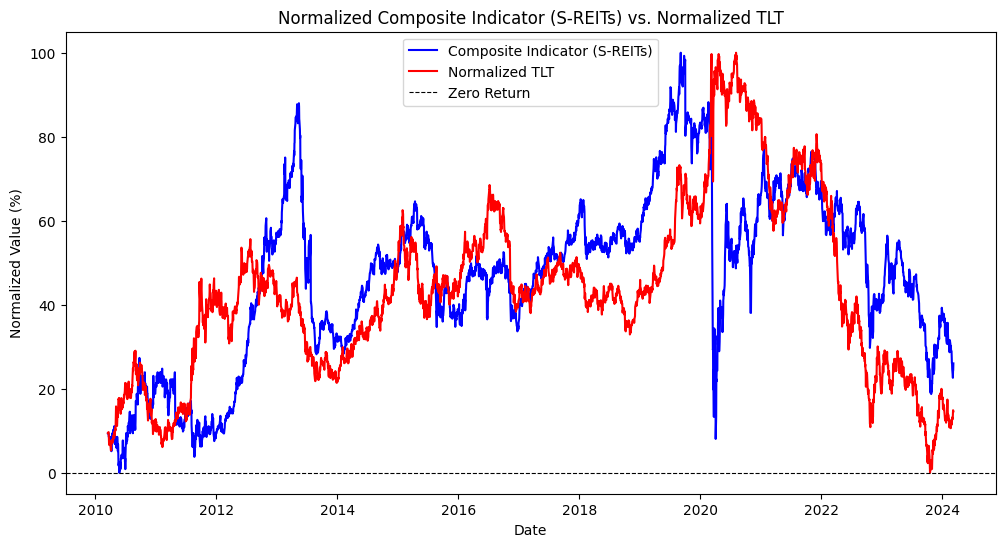

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# List of S-REITs ticker symbols
s_reits_tickers = ['JYEU.SI', 'N2IU.SI', 'J69U.SI', 'BUOU.SI', 'SK6U.SI']
# Ticker symbol for TLT
tlt_ticker = 'TLT'

# Download historical data for S-REITs
s_reits_data = yf.download(s_reits_tickers, start='2010-03-17', end='2024-03-09')['Close']
# Download historical data for TLT
tlt_data = yf.download(tlt_ticker, start='2010-03-17', end='2024-03-09')['Close']

# Calculate cumulative returns for S-REITs and TLT
s_reits_cumulative_returns = (1 + s_reits_data.pct_change()).cumprod() - 1
tlt_cumulative_returns = (1 + tlt_data.pct_change()).cumprod() - 1

# Normalize cumulative returns using MinMaxScaler
scaler = MinMaxScaler()
s_reits_cumulative_returns_normalized = scaler.fit_transform(s_reits_cumulative_returns)
tlt_cumulative_returns_normalized = scaler.fit_transform(tlt_cumulative_returns.values.reshape(-1, 1))

# Create composite indicators for S-REITs and TLT
s_reits_composite_indicator = s_reits_cumulative_returns.mean(axis=1)
tlt_composite_indicator = tlt_cumulative_returns.squeeze()

# Normalize composite indicators using MinMaxScaler
s_reits_composite_indicator_normalized = scaler.fit_transform(s_reits_composite_indicator.values.reshape(-1, 1))

# Plot the normalized composite indicators for S-REITs and TLT
plt.figure(figsize=(12, 6))

plt.plot(s_reits_cumulative_returns.index, s_reits_composite_indicator_normalized * 100, label='Composite Indicator (S-REITs)', color='blue')
plt.plot(tlt_cumulative_returns.index, tlt_cumulative_returns_normalized * 100, label='Normalized TLT', color='red')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Return')
plt.title('Normalized Composite Indicator (S-REITs) vs. Normalized TLT')
plt.xlabel('Date')
plt.ylabel('Normalized Value (%)')
plt.legend()
plt.show()


In [ ]:
# Compute the correlation between TLT and the composite indicator of S-REITs
correlation = tlt_composite_indicator.corr(s_reits_composite_indicator)

print("Correlation between TLT and Composite Indicator (S-REITs):", correlation)


Correlation between TLT and Composite Indicator (S-REITs): 0.5841730284516078


[*********************100%%**********************]  1 of 1 completed


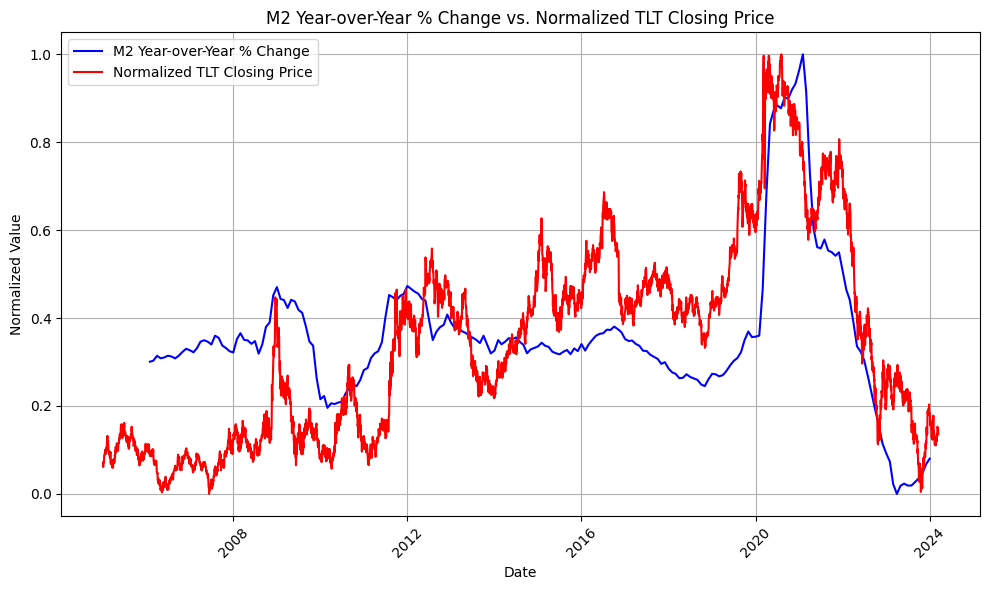

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# Read the M2 data from the CSV file into a DataFrame
M2_df = pd.read_csv('M2SL.csv')

# Convert 'DATE' column to datetime
M2_df['DATE'] = pd.to_datetime(M2_df['DATE'])

# Filter the M2 DataFrame to include only the rows between 2020 and 2024
M2_filtered = M2_df[(M2_df['DATE'] >= '2005-01-01') & (M2_df['DATE'] <= '2024-12-31')]

# Download TLT data from Yahoo Finance
tlt_data = yf.download('TLT', start='2005-01-01', end='2024-12-31')

# Normalize M2 and TLT data
scaler = MinMaxScaler()

# Normalize M2 data
M2_filtered['M2SL_PC1_normalized'] = scaler.fit_transform(M2_filtered[['M2SL_PC1']])

# Normalize TLT data
tlt_data['Close_normalized'] = scaler.fit_transform(tlt_data[['Close']])

# Plot M2 year-over-year percentage change and normalized TLT closing price
plt.figure(figsize=(10, 6))

# Plot M2
plt.plot(M2_filtered['DATE'], M2_filtered['M2SL_PC1_normalized'], label='M2 Year-over-Year % Change', color='blue')

# Plot normalized TLT closing price
plt.plot(tlt_data.index, tlt_data['Close_normalized'], label='Normalized TLT Closing Price', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('M2 Year-over-Year % Change vs. Normalized TLT Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
